In [98]:
file_path = "./titanic"
gender_file_name = "gender_submission.csv"
test_file_name = "test.csv"
train_file_name = "train.csv"

In [106]:
from os import path
gender_file_path = path.join(file_path, gender_file_name)
test_file_path = path.join(file_path, test_file_name)
train_file_path = path.join(file_path, train_file_name)

In [112]:
import pandas as pd
import numpy as np
Gender_data = pd.read_csv(gender_file_path)
Test_data = pd.read_csv(test_file_path)
Train_data = pd.read_csv(train_file_path)

In [113]:
print(Gender_data.info())
print(Train_data.info())
print(Test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 


array([[<AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='Parch', ylabel='Survived'>,
        <AxesSubplot:xlabel='Fare', ylabel='Survived'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Age', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Parch', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Fare', ylabel='Pclass'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Age'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Age'>,
        <AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='Parch', ylabel='Age'>,
        <AxesSubplot:xlabel='Fare', ylabel='Age'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Parch'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Parch'>,
        <AxesSubplot:xlabel='Age', ylabel='Parch'>,
        <A

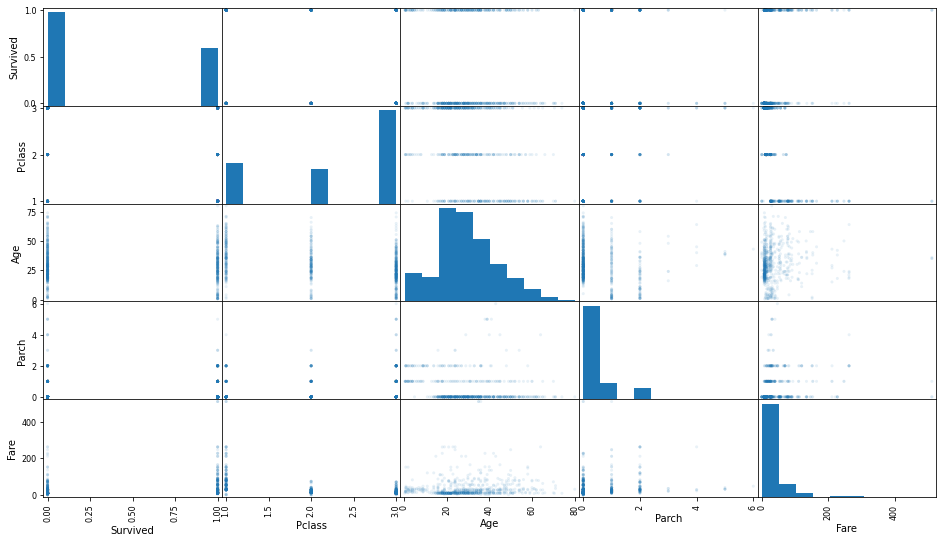

In [114]:
from pandas.plotting import scatter_matrix
attributes = ["Survived", "Pclass", "Age", "Parch", "Fare"]
scatter_matrix(Train_data[attributes], figsize=(16,9), alpha=.1)

In [124]:
y_train = Train_data["Survived"]
Train_data.drop(columns=["Survived", "Cabin", "Ticket", "Name", "PassengerId"], inplace=True)
X_train = Train_data
print(X_train.info())
print(y_train.shape)

KeyError: 'Survived'

In [125]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
attribs_to_scale = ["Pclass", "SibSp", "Parch", "Fare"]


class fillval(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(value="S")

name_pipeline = Pipeline([
    ('sparsevec', sparsevec())
])

age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', MinMaxScaler())
])

embarked_pipeline = Pipeline([
    ('fill', fillval()),
    ('encoder', OrdinalEncoder()),
    ('std_scaler', MinMaxScaler()),
])

sex_pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('std_scaler', MinMaxScaler())
])

standard_pipeline = Pipeline([
    ('std_scaler', MinMaxScaler())
])

full_pipeline = ColumnTransformer([
    ("age", age_pipeline, ["Age"]),
    ("embarked", embarked_pipeline, ["Embarked"]),
    ("sex", sex_pipeline, ["Sex"]),
    ("scaler", standard_pipeline, attribs_to_scale)
])

X_train_prep = full_pipeline.fit_transform(X_train)

In [126]:
print(X_train_prep.shape)

(891, 7)


In [127]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(X_train_prep, y_train)

RandomForestClassifier(random_state=42)

In [128]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_clf, X_train_prep, y_train, cv=3, scoring="accuracy")
print(scores)

[0.77104377 0.82828283 0.79124579]


In [129]:
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [130]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators' : [100, 300, 1000], 'min_samples_leaf' : [2, 3, 4]}
grid_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)

In [ ]:
grid_search.fit(X_train_prep, y_train)
cvres = grid_search.cv_results_

In [ ]:
for score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(score, params)

In [ ]:
X_Test = Test_data.drop(columns=["Cabin", "Name", "Ticket", "PassengerId"])
Test_data_prep = full_pipeline.fit_transform(X_Test)

In [ ]:
trans = pd.DataFrame(Test_data_prep, columns=X_Test.columns, index=X_Test.index)
trans["Embarked"] = trans["Embarked"].fillna(value=.0157)
predictions = forest_clf.predict(trans)
print(predictions)
my_submission = pd.DataFrame({'PassengerId': Test_data["PassengerId"], 'Survived': predictions})

In [383]:
my_submission['PassengerId'].shape
my_submission.to_csv('./submission.csv', index = False, header= 1)